## Data Extraction and Visualizations

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from tqdm import tqdm

In [2]:
from scipy.io import wavfile
import librosa ## For Audio in Python
from python_speech_features import mfcc, logfbank  ## To digital Signal Processing

C:\Users\Point_Break\AppData\Roaming\Python\Python36\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [3]:
def plot_signals(signals):
    fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=True, figsize=(20,5))
    fig.suptitle('Time Series', size=16)
    i = 0
    for x in range(1):
        for y in range(2):
            axes[y].set_title(list(signals.keys())[i])
            axes[y].plot(list(signals.values())[i])
            i += 1

In [4]:
def plot_fft(fft):
    fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=True, figsize=(20,5))
    fig.suptitle('Fourier Transforms', size=16)
    i = 0
    for x in range(1):
        for y in range(2):
            data = list(fft.values())[i]
            Y, freq = data[0], data[1]
            axes[y].set_title(list(fft.keys())[i])
            axes[y].plot(freq, Y)
            i += 1

In [5]:
def plot_fbank(fbank):
    fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=True, figsize=(20,5))
    fig.suptitle('Filter Bank Coefficients', size=16)
    i = 0
    for x in range(1):
        for y in range(2):
            axes[y].set_title(list(fbank.keys())[i])
            axes[y].imshow(list(fbank.values())[i], cmap='hot', interpolation='nearest')
            i += 1

In [6]:
def plot_mfccs(mfccs):
    fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=True, figsize=(20,5))
    fig.suptitle('Mel Frequency Cepstrum Coefficients', size=16)
    i = 0
    for x in range(1):
        for y in range(2):
            axes[y].set_title(list(mfccs.keys())[i])
            axes[y].imshow(list(mfccs.values())[i], cmap='hot', interpolation='nearest')
            i += 1

In [7]:
def calc_fft(y, rate):
    n = len(y)
    freq = np.fft.rfftfreq(n, d = 1/rate)
    Y = abs(np.fft.rfft(y)/n)
    return (Y, freq)

In [8]:
def envelope(y, rate, threshold):
    mask = []
    y = pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window = int(rate/10), min_periods = 1, center = True).mean()
    for mean in y_mean:
        if mean > threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask

## Data Extraction

In [9]:
os.listdir('Temp_Dataset/')

['test', 'train', 'validation']

In [10]:
os.listdir('Temp_Dataset/train/')

['not_sick', 'sick']

In [11]:
classes = list(os.listdir('Temp_Dataset/train/'))

print("Number of Classes in the Data Set:", len(classes), "Classes")
print("The classes of the dataset are   :", classes[0], ",", classes[1])

Number of Classes in the Data Set: 2 Classes
The classes of the dataset are   : not_sick , sick


In [12]:
column_names = ['Fname','Class', 'Length']
df = pd.DataFrame(columns = column_names)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 3 columns):
Fname     0 non-null object
Class     0 non-null object
Length    0 non-null object
dtypes: object(3)
memory usage: 0.0+ bytes


In [13]:
df.head() ## The dataframe is empty as of now

Empty DataFrame
Columns: [Fname, Class, Length]
Index: []

In [14]:
#dataset_directory = 'Dataset/Train/'
dataset_directory = 'Temp_Dataset/Train/'

In [15]:
for c in list(classes):
    print('Number of files in the directory \'{}\' are {}'.format(c,len(os.listdir(dataset_directory+c))))

Number of files in the directory 'not_sick' are 385
Number of files in the directory 'sick' are 313


In [16]:
for c in list(classes):
    for n,f in enumerate(os.listdir(dataset_directory+c)):
        rate, signal = wavfile.read(dataset_directory+str(c)+"/"+str(f))
        length = signal.shape[0]/rate
        f_df = pd.DataFrame({
            "Fname": str(f),
            "Class": str(c),
            "Length": length}, index = [n])
        df = df.append(f_df)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 698 entries, 0 to 312
Data columns (total 3 columns):
Fname     698 non-null object
Class     698 non-null object
Length    698 non-null float64
dtypes: float64(1), object(2)
memory usage: 21.8+ KB


In [19]:
df.set_index('Fname', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 698 entries, 02Sa2hBL_48_25_30.wav to _zrAnhgYzSo_15_20.wav
Data columns (total 2 columns):
Class     698 non-null object
Length    698 non-null float64
dtypes: float64(1), object(1)
memory usage: 16.4+ KB


In [20]:
df.head()

Class   Length
Fname                                     
02Sa2hBL_48_25_30.wav    not_sick  4.98449
03l610T5nfY_405_410.wav  not_sick  4.98449
05FErJX7xOU_65_70.wav    not_sick  4.98449
05YBpmCnoOQ_50_55.wav    not_sick  5.01551
06YwLqlR1Jc_60_65.wav    not_sick  5.01551

In [21]:
class_dist = df.groupby(['Class'])['Length'].mean()

class_dist

Class
not_sick    4.999960
sick        5.000198
Name: Length, dtype: float64

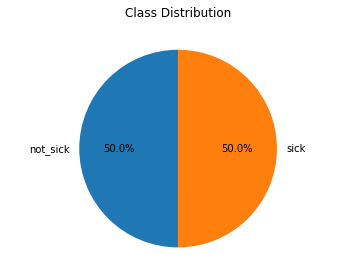

In [22]:
fig, ax = plt.subplots()
ax.set_title("Class Distribution", y=1.08)
ax.pie(class_dist, labels = class_dist.index, autopct = '%1.1f%%',
      shadow = False, startangle=90)
ax.axis('equal')
plt.show()

## Visualization of Audio Data in Both Classes and Feature Extraction

In [23]:
df.reset_index(inplace=True)

In [24]:
signals = {}
fft     = {}
fbank   = {}
mfccs   = {}

The audio File is 4K6GbEsq0xk_25_30.wav


The audio File is 9SwqisZFZr8_30_35.wav


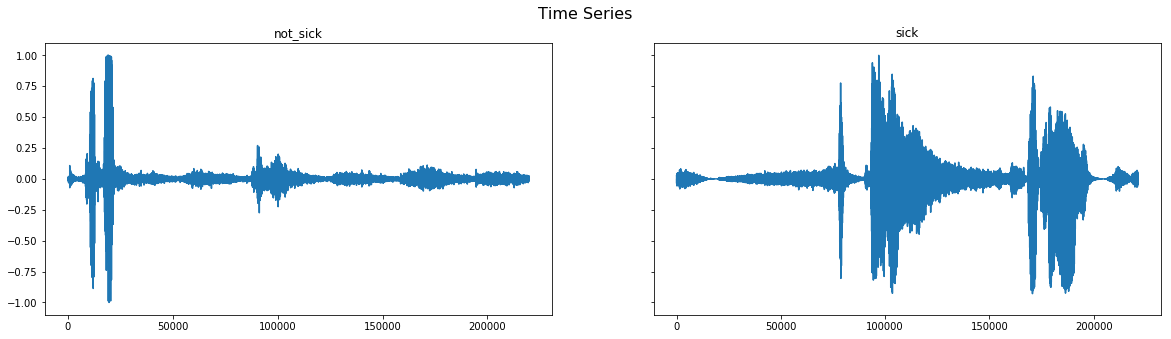

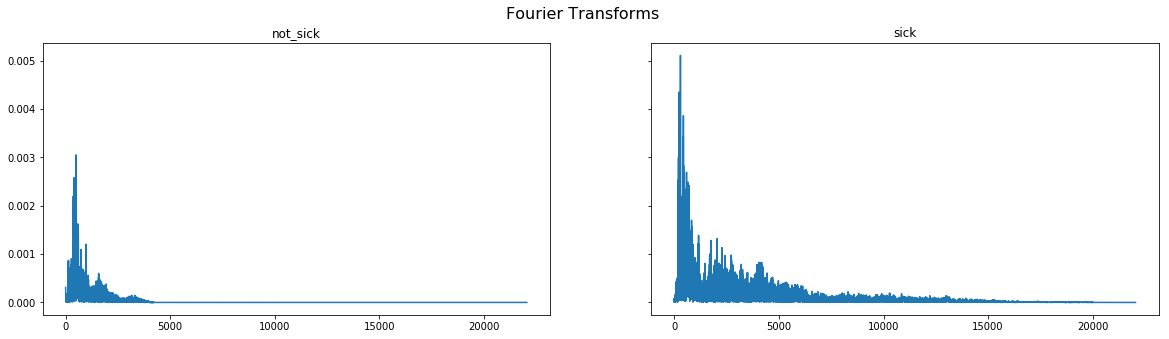

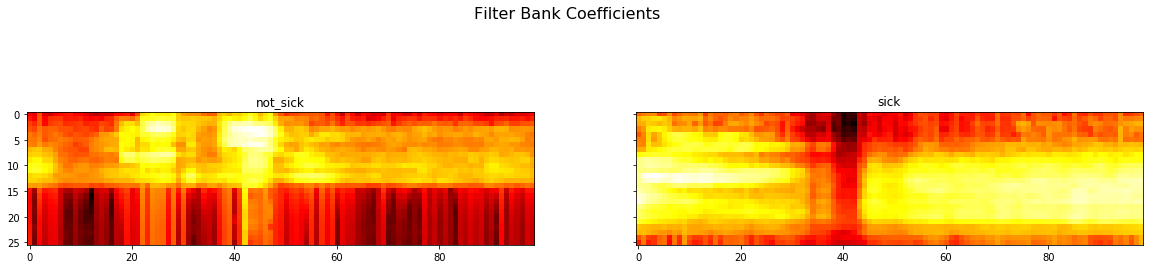

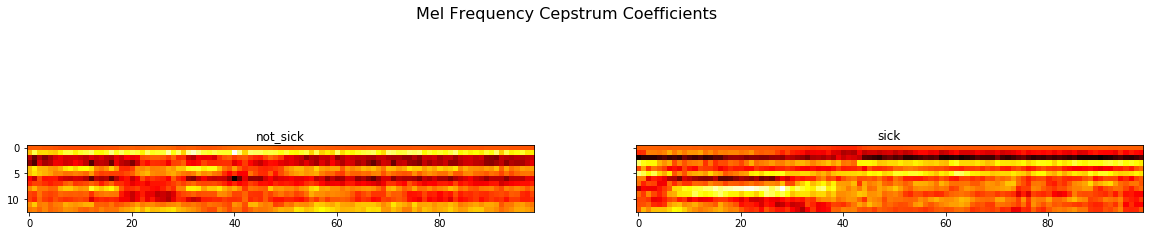

In [25]:
for c in classes:
    
    wav_file = df[df.Class == c].iloc[int(np.random.choice(df[df.Class == c].shape[0])),0]
    print("The audio File is {}".format(wav_file))    
    display.display(display.Audio(dataset_directory+c+"/"+wav_file))
    
    signal, rate = librosa.load(dataset_directory+c+"/"+wav_file, sr=44100)
    
    signals[c] = signal
    fft[c] = calc_fft(signal, rate)
    
    bank = logfbank(signal[:rate], rate, nfilt=26, nfft=1103).T
    fbank[c] = bank
    
    mel = mfcc(signal[:rate], rate, numcep= 13, nfilt=26, nfft= 1103).T
    mfccs[c] = mel

plot_signals(signals)

plot_fft(fft)

plot_fbank(fbank)

plot_mfccs(mfccs)
plt.show()

The audio File is audioset__pxnSaDou3I_5_10.wav


The audio File is audioset_2a0ZcVUlce0_85_90.wav


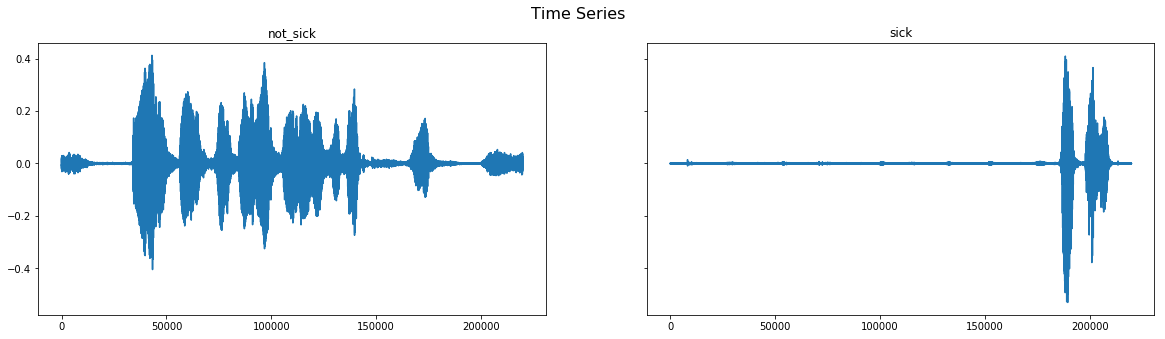

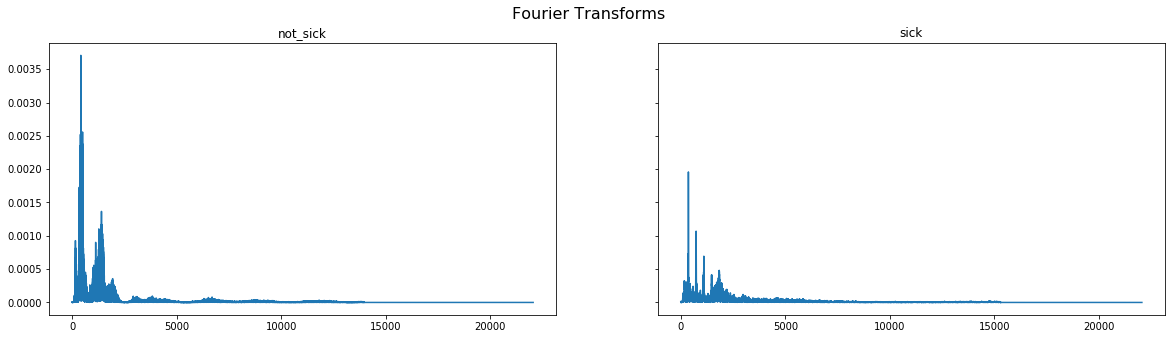

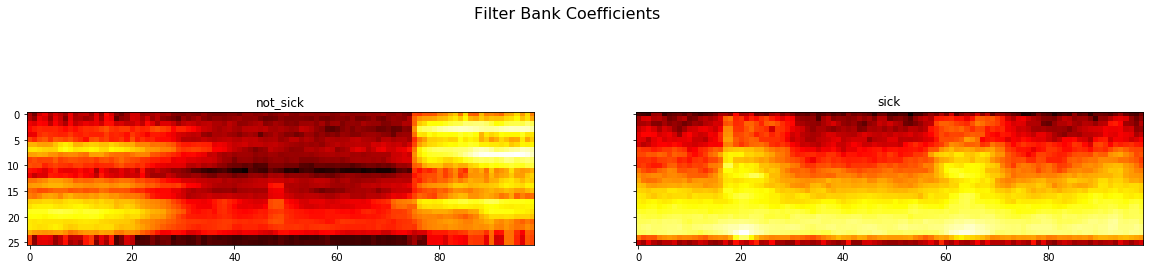

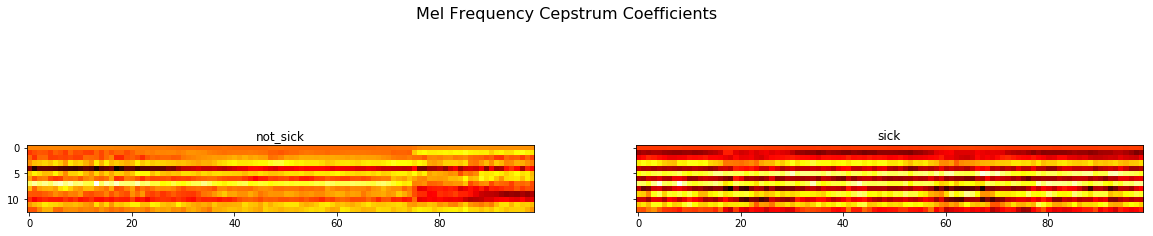

The audio File is audioset_0uEZjp0UE0E_180_185.wav


The audio File is audioset_0pM8_hyW8SU_135_140.wav


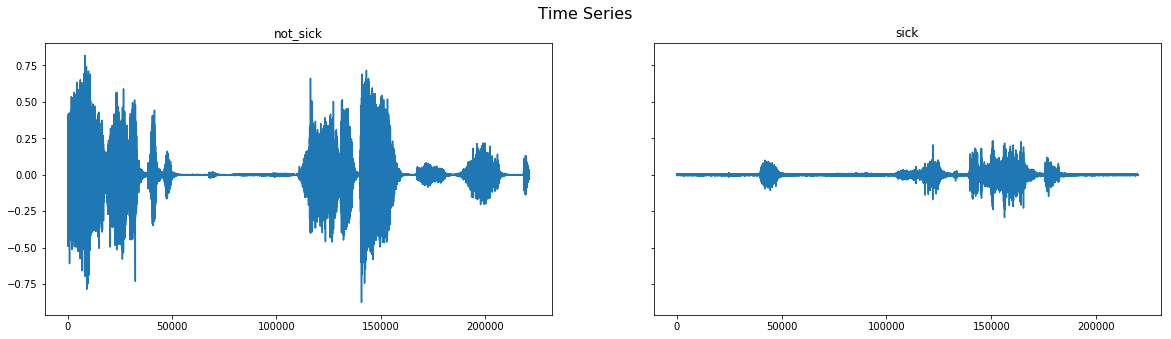

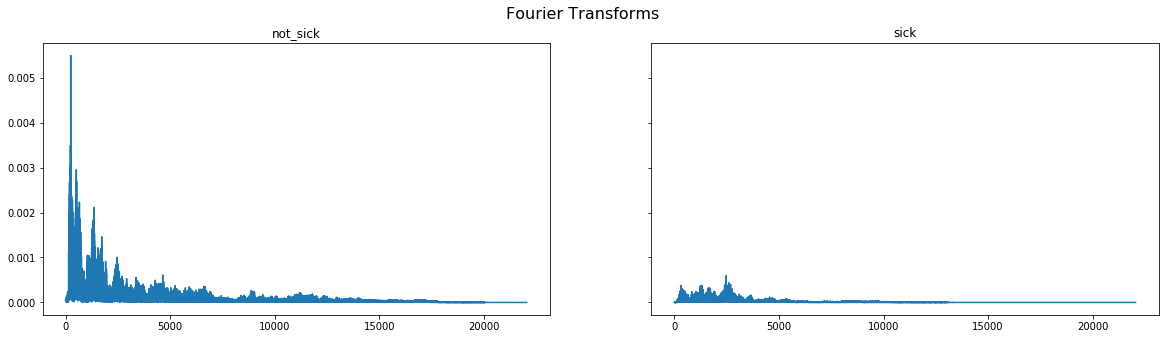

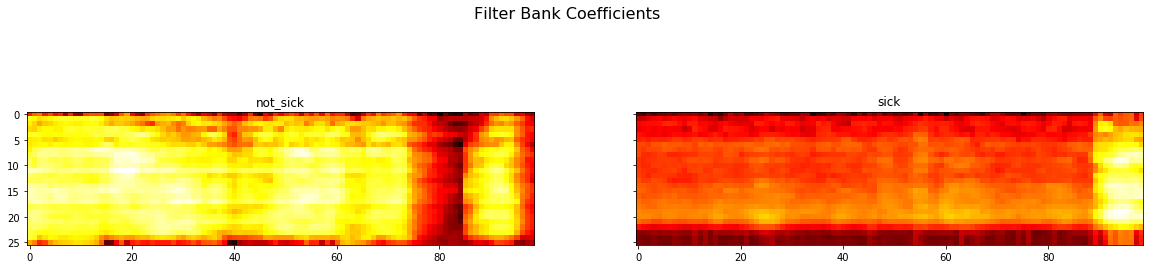

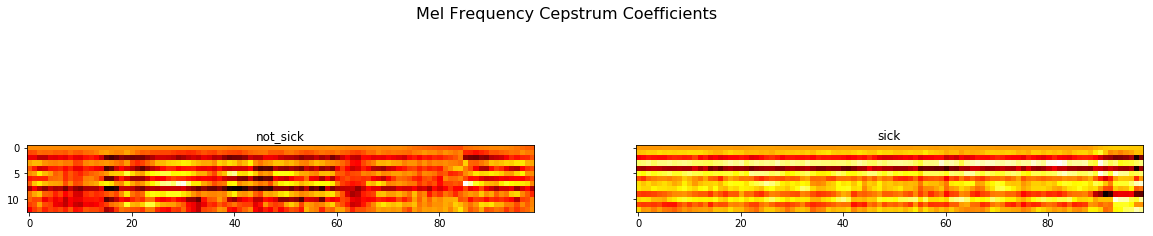

The audio File is audioset_2BxY32GiQt8_425_430.wav


The audio File is audioset_0ry6MOZmmf4_30_35.wav


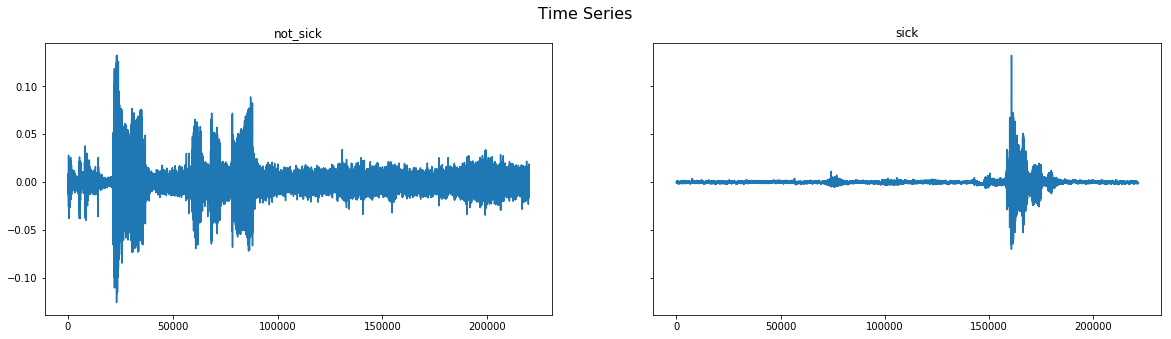

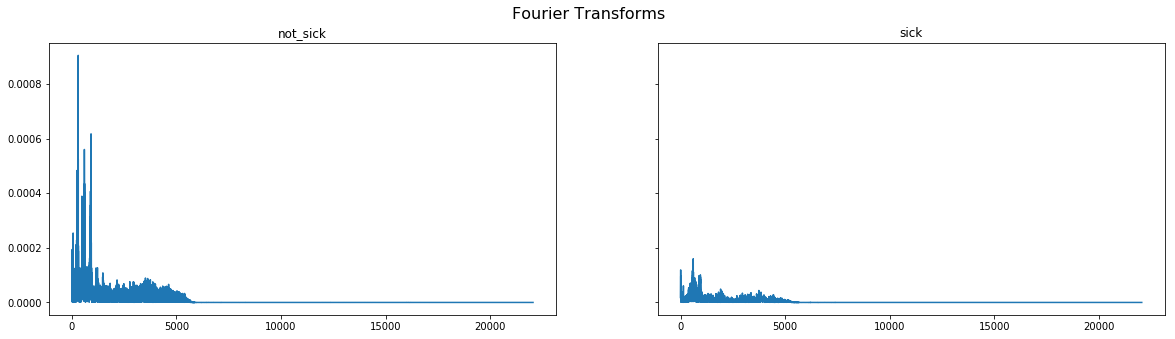

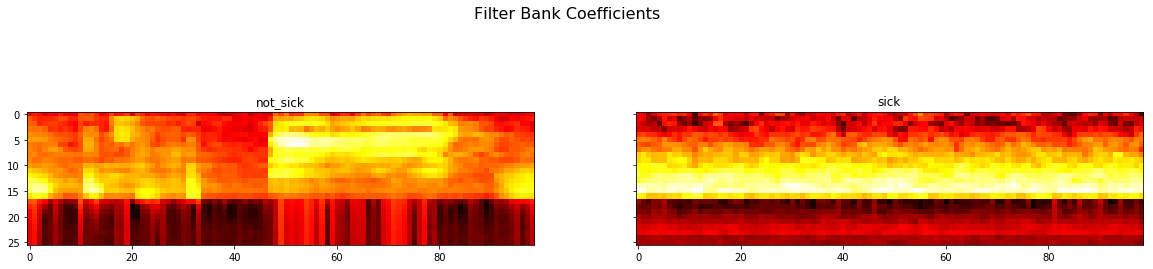

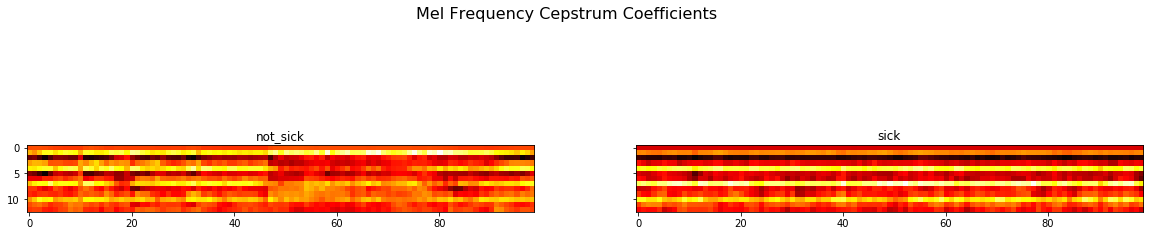

The audio File is audioset_4yx_l1QFrzw_280_285.wav


The audio File is audioset__TXc9-Qitpk_45_50.wav


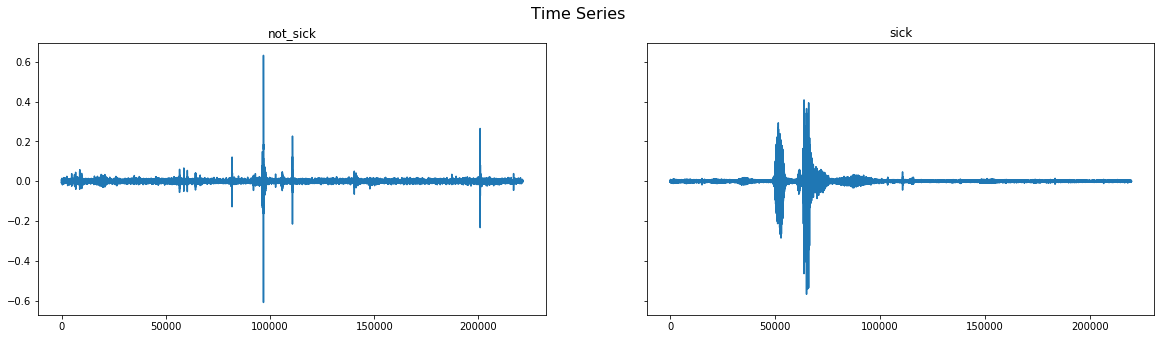

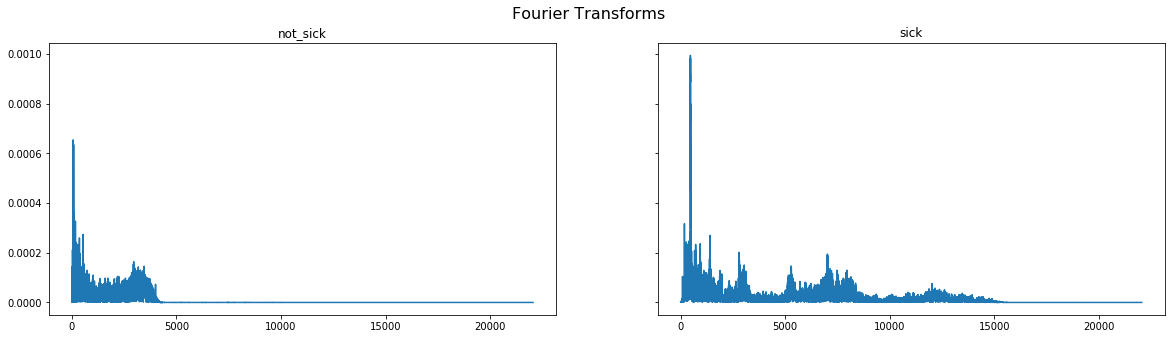

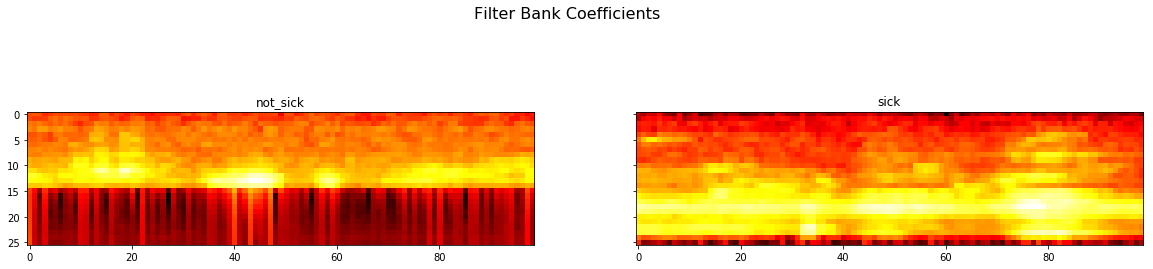

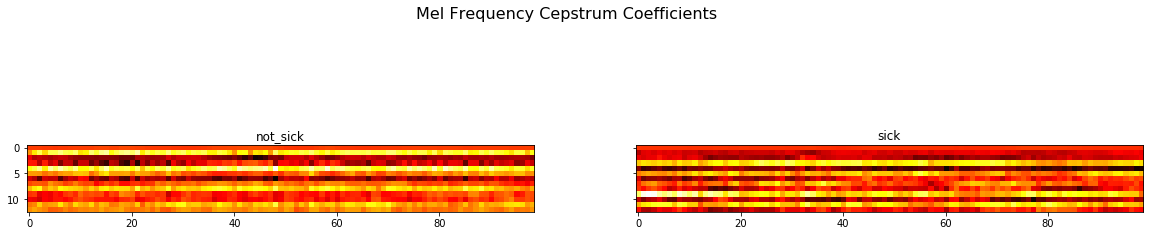

The audio File is audioset_3lasyHceYLo_33_38.wav


The audio File is audioset_0rNFshd9OEc_45_50.wav


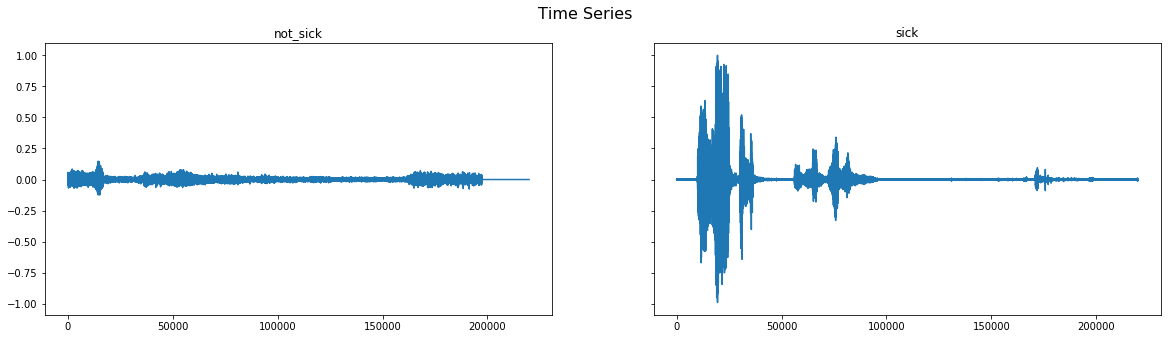

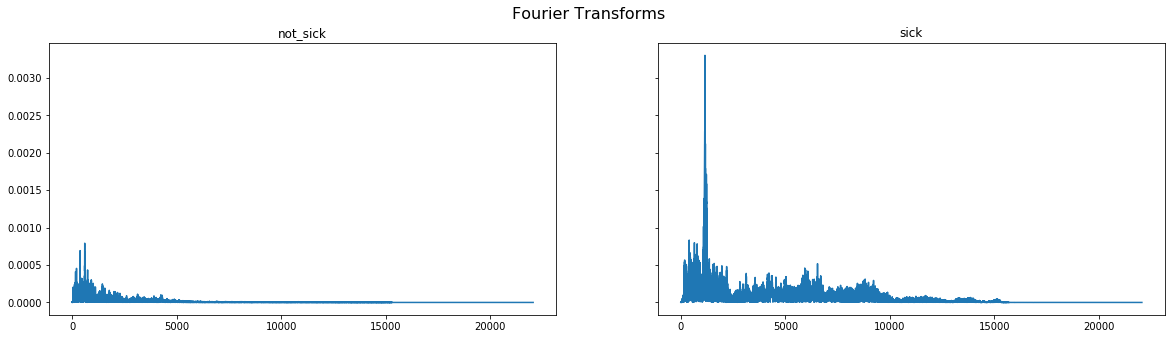

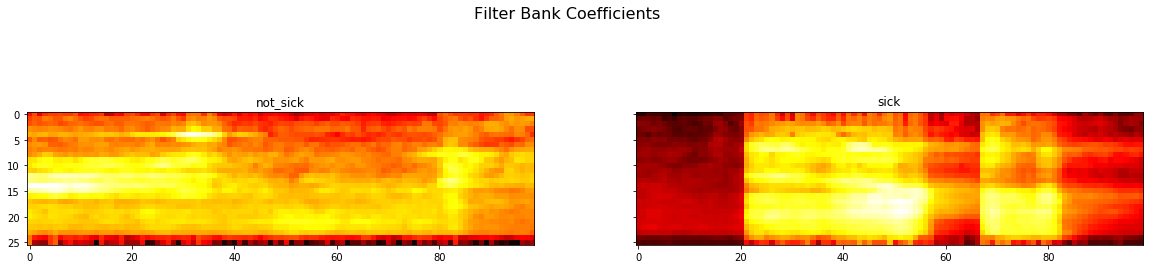

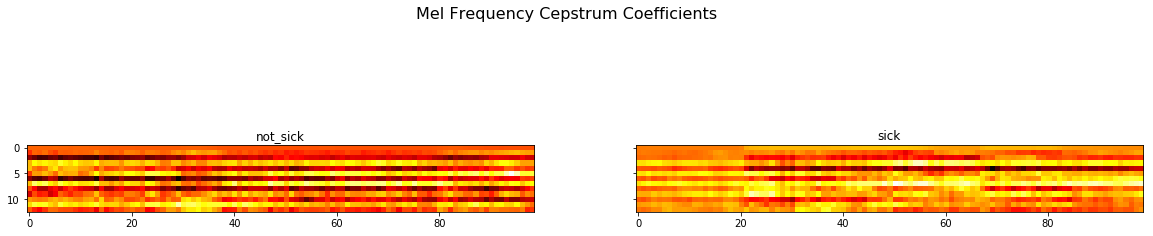